In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import time

In [2]:
# tf.debugging.set_log_device_placement(True)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
            
            print(e)

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
target_files = tf.io.gfile.glob(str('photo_tfrec/photo*.tfrec'))
target_files

['photo_tfrec\\photo00-352.tfrec',
 'photo_tfrec\\photo01-352.tfrec',
 'photo_tfrec\\photo02-352.tfrec',
 'photo_tfrec\\photo03-352.tfrec',
 'photo_tfrec\\photo04-352.tfrec',
 'photo_tfrec\\photo05-352.tfrec',
 'photo_tfrec\\photo06-352.tfrec',
 'photo_tfrec\\photo07-352.tfrec',
 'photo_tfrec\\photo08-352.tfrec',
 'photo_tfrec\\photo09-352.tfrec',
 'photo_tfrec\\photo10-352.tfrec',
 'photo_tfrec\\photo11-352.tfrec',
 'photo_tfrec\\photo12-352.tfrec',
 'photo_tfrec\\photo13-352.tfrec',
 'photo_tfrec\\photo14-352.tfrec',
 'photo_tfrec\\photo15-352.tfrec',
 'photo_tfrec\\photo16-352.tfrec',
 'photo_tfrec\\photo17-352.tfrec',
 'photo_tfrec\\photo18-352.tfrec',
 'photo_tfrec\\photo19-350.tfrec']

In [6]:
# check what is inside the tfrec
test_dataset=tf.data.TFRecordDataset(target_files[0])
for raw_record in test_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\035\000\000\001\005\001\001\001\001\000\000\000\000\000\000\000\000\000\004\002\003\005\006\007\001\010\000\t\377\304\000@\020\000\001\002\004\004\004\005\001\006\003\010\002\003\001\001\000\002\003\004\000\001\005\022\006\021\"2\007\023!B\010\0241RbA\025#Qar\202\026\222\242\t$3q\201\221\241\262C\302S\360\362\027&\377\304\000\033\001\000\002\

In [7]:
HEIGHT=256
WIDTH=256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128

In [8]:
def data_augment(image):
    p_spatial=tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate=tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate> 0.8:
        image = tf.image.rot90(image, k=3)
    elif p_rotate>0.6:
        image = tf.image.rot90(image, k=2)
    elif p_rotate>0.4:
        image = tf.image.rot90(image, k=1)
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial>0.75:
        image = tf.image.transpose(image)
        
#     image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, 3])
    
    return image

In [9]:
def image_decode(coded_im):
    with tf.device('/device:cpu:0'):
        image=tf.image.decode_jpeg(coded_im, channels=3)
        image=(tf.cast(image, tf.float32)/127.5)-1
        image=tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

In [10]:
def read_tfrecord(example):
    tfrecord_format={
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example=tf.io.parse_single_example(example, tfrecord_format)
    image=image_decode(example['image'])
    return image

In [11]:
def load_dataset(filenames):
    dataset=tf.data.TFRecordDataset(filenames)
    dataset=dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [12]:
def create_grayscale(example):
    with tf.device('/device:cpu:0'):
        image = example[0]
        gs_image = tf.image.rgb_to_grayscale(image)
        gs_example = tf.expand_dims(gs_image, 0)
    return gs_example

In [13]:
photo_ds = load_dataset(target_files[0])

gray_scale_ds = photo_ds.map(tf.image.rgb_to_grayscale, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [14]:
photo_list = list(iter(photo_ds))
gray_scale_list = list(iter(gray_scale_ds))

In [15]:
print(len(photo_list), len(gray_scale_list))

352 352


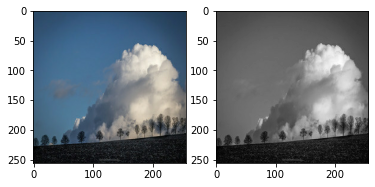

In [16]:
plt.subplot(121)
plt.imshow(photo_list[0]*0.5 + 0.5)
plt.subplot(122)
plt.imshow(gray_scale_list[0]*0.5 + 0.5, cmap = plt.cm.gray)

In [17]:
# gray_scale_list[0]*0.5

In [18]:
def load_training_dataset(filenames, batch_size=1, repeat=True):
    photo_ds = load_dataset(filenames)
    
    photo_ds = photo_ds.map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if repeat:
        photo_ds = photo_ds.repeat()
    
    photo_ds = photo_ds.shuffle(2048)
    
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    photo_ds.cache()
    photo_ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return photo_ds

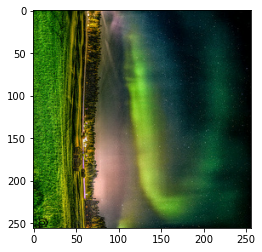

In [19]:
training_ds = load_training_dataset(target_files[0], repeat=False)
training_list = list(iter(training_ds))
aug_image = training_list[0]
# print(test_image)
plt.subplot()
plt.imshow(aug_image[0]*0.5 + 0.5)

In [20]:
print(tf.shape(aug_image))
image = aug_image[0]
gs_image = tf.image.rgb_to_grayscale(image)
gs_example = tf.expand_dims(gs_image, 0)
print(tf.shape(gs_example))

tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)
tf.Tensor([  1 256 256   1], shape=(4,), dtype=int32)


## Downsample and upsample blocks

In [21]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(gs_example)
print (down_result.shape)

(1, 128, 128, 3)


In [23]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [24]:
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


## Generator & Discriminator

In [25]:
def Generator():
    inputs=tf.keras.layers.Input(shape=[256, 256, 1])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128,4), # (bs, 64, 64, 128)
        downsample(256,4), # (bs, 32, 32, 256)
        downsample(512,4), # (bs, 16, 16, 512)
        downsample(512,4), # (bs, 8,   8, 512)
        downsample(512,4), # (bs, 4,   4, 512)
        downsample(512,4), # (bs, 2,   2, 512)
        downsample(512,4), # (bs, 1,   1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs,  2,  2, 1024) 1024 is due to concatenate
        upsample(512, 4, apply_dropout=True), # (bs,  4,  4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs,  8,  8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64,  4), # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.2)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', 
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x=down(x)
        skips.append(x)
    
    skips=reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x=up(x)
        x=tf.keras.layers.Concatenate()([x, skip])
        
    x=last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

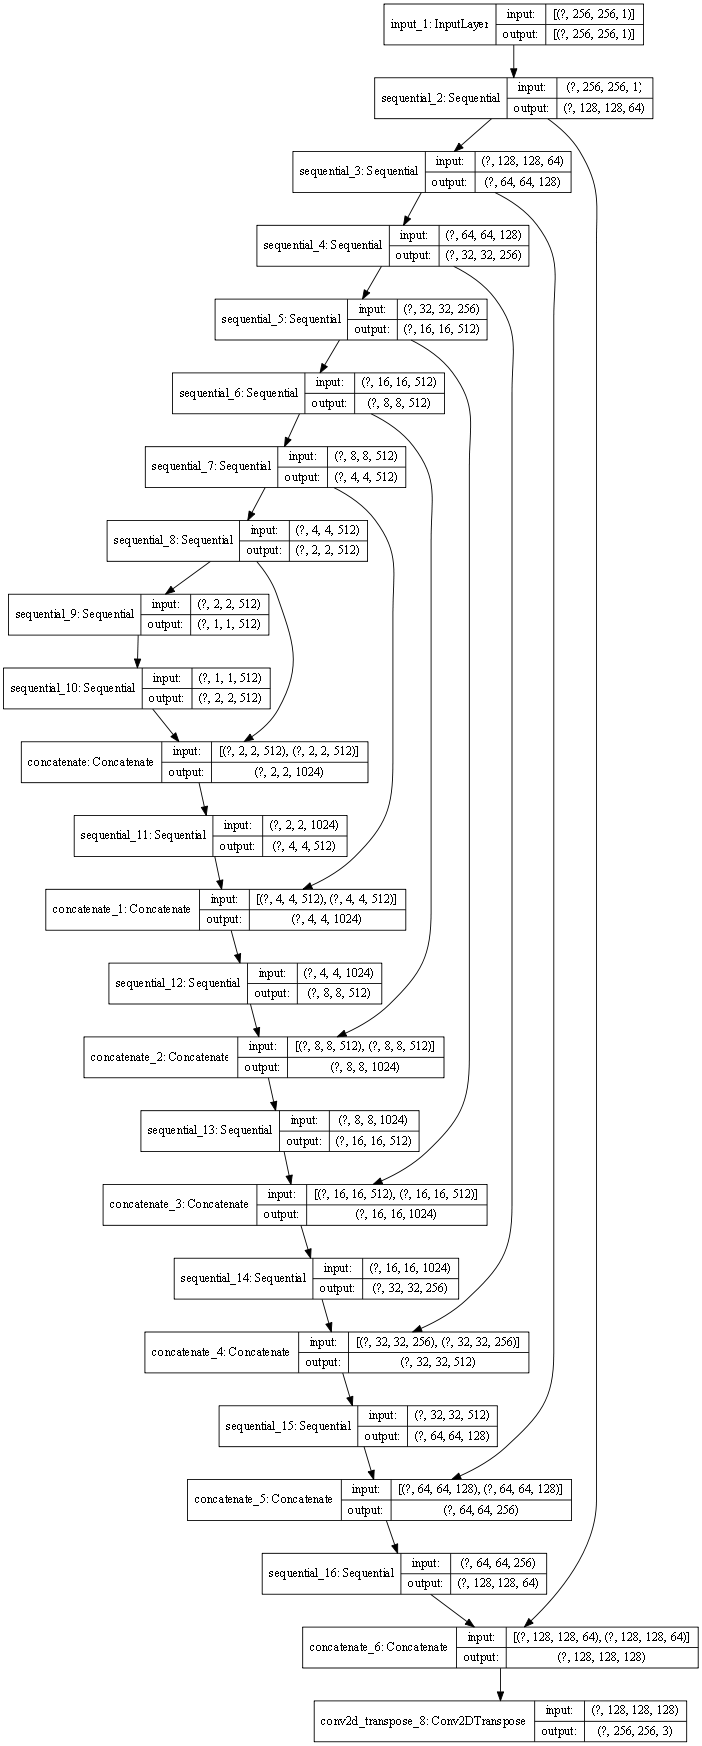

In [26]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

-0.99990004
0.9906922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 256, 256,   3])>

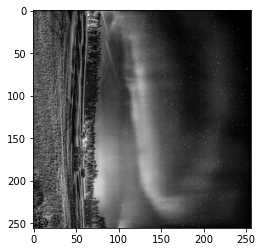

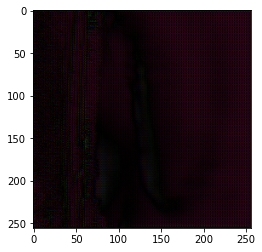

In [27]:
test_gray = create_grayscale(aug_image)
tf.shape(test_gray)
print(np.ndarray.min(test_gray.numpy()))
print(np.ndarray.max(test_gray.numpy()))
plt.figure(1)
plt.imshow(test_gray[0], cmap = plt.cm.gray)
gen_output=generator(test_gray, training=False)
plt.figure(2)
plt.imshow(gen_output[0,...])
tf.shape(gen_output)

In [28]:
LAMBDA = 100

In [29]:
def generator_loss(disc_gen_output, gen_output, target):
    gan_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_gen_output),
                                                                  disc_gen_output)
    
    l1_loss=tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

In [30]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    
    x = tf.keras.layers.concatenate([inp, tar])
    
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 128)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) #(bs, 31, 31, 512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1, 
                                  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
    

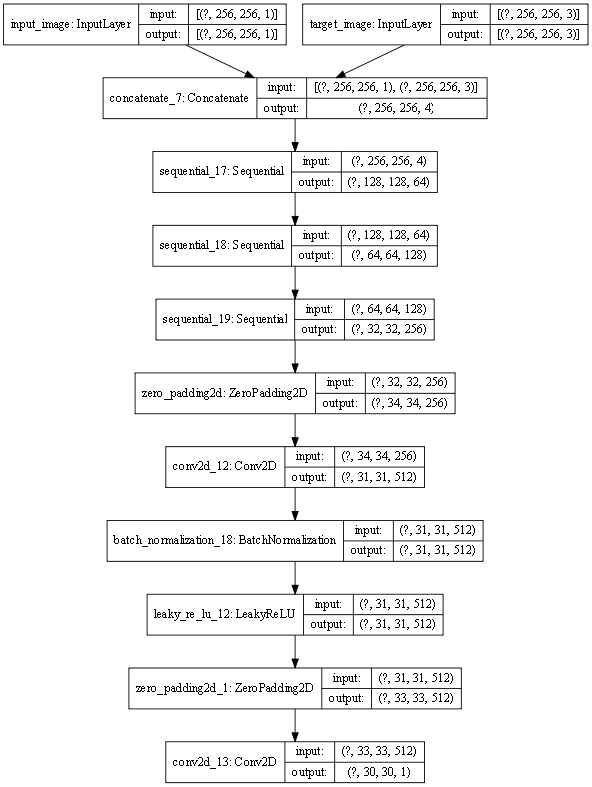

In [31]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

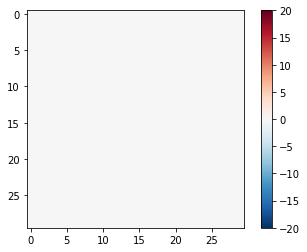

In [32]:
disc_out=discriminator([test_gray, gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [33]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output),
                                                                  disc_real_output)
    
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_gen_output),
                                                                  disc_gen_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoint

In [35]:
checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored !!')

Latest checkpoint restored !!


In [36]:
ckpt_manager.latest_checkpoint

'./training_checkpoints\\ckpt-29'

In [37]:
def generate_images(model, test_input, tar, epoch):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.figure(epoch, figsize=(19,6))
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        if i == 0:
            plt.imshow(display_list[i] * 0.5 + 0.5, cmap = plt.cm.gray)
        else:
            plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Visualize result test

<Figure size 1080x1080 with 0 Axes>

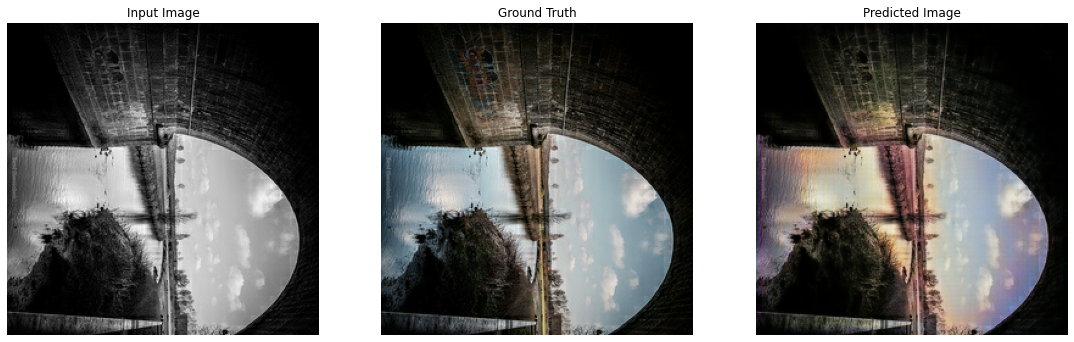

In [38]:
for example_target in training_ds.take(1):
    example_input = create_grayscale(example_target)
    generate_images(generator, example_input, example_target,0)

In [39]:
EPOCHS = 3

In [40]:
import datetime
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

## Build model

In [41]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_gen_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_gen_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [42]:
def fit(train_ds, epochs, steps_per_epoch):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait=True)
        
        for example_target in train_ds.take(1):
            example_input = create_grayscale(example_target)
            generate_images(generator, example_input, example_target, epoch)
        print("Epoch:", epoch)
        
        # train
        for n, target in train_ds.enumerate():
            if n>=steps_per_epoch:
                break
            print('now:{}'.format(n), end='->')
            if (n+1) % 100 == 0:
                print()
            gs_input = create_grayscale(target) # create gray scale image from target image
            train_step(gs_input, target, epoch)
        print()
        
        # saving (checkpoint) the model every 20 epochs
        if (epoch+1) % 2 == 0 or epoch==0:
            
            ckpt_save_path = ckpt_manager.save()
            print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
        
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
        
    checkpoint.save(file_prefix=checkpoint_prefix)

In [43]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

## Training

In [44]:
formal_train_dataset = load_training_dataset(target_files, repeat=True)

<Figure size 1080x1080 with 0 Axes>

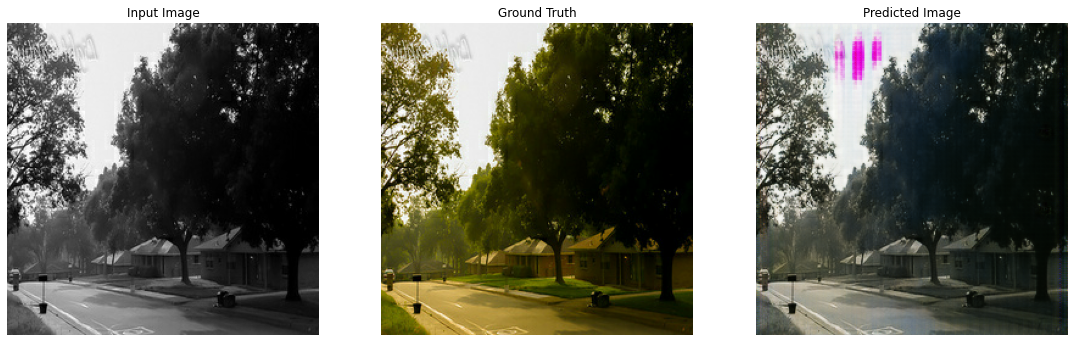

Epoch: 49
now:0->WARNING:tensorflow:AutoGraph could not transform <bound method DescriptorBase.GetOptions of <google.protobuf.descriptor.Descriptor object at 0x000002055878E470>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbos

now:1400->now:1401->now:1402->now:1403->now:1404->now:1405->now:1406->now:1407->now:1408->now:1409->now:1410->now:1411->now:1412->now:1413->now:1414->now:1415->now:1416->now:1417->now:1418->now:1419->now:1420->now:1421->now:1422->now:1423->now:1424->now:1425->now:1426->now:1427->now:1428->now:1429->now:1430->now:1431->now:1432->now:1433->now:1434->now:1435->now:1436->now:1437->now:1438->now:1439->now:1440->now:1441->now:1442->now:1443->now:1444->now:1445->now:1446->now:1447->now:1448->now:1449->now:1450->now:1451->now:1452->now:1453->now:1454->now:1455->now:1456->now:1457->now:1458->now:1459->now:1460->now:1461->now:1462->now:1463->now:1464->now:1465->now:1466->now:1467->now:1468->now:1469->now:1470->now:1471->now:1472->now:1473->now:1474->now:1475->now:1476->now:1477->now:1478->now:1479->now:1480->now:1481->now:1482->now:1483->now:1484->now:1485->now:1486->now:1487->now:1488->now:1489->now:1490->now:1491->now:1492->now:1493->now:1494->now:1495->now:1496->now:1497->now:1498->now:1499->

now:3000->now:3001->now:3002->now:3003->now:3004->now:3005->now:3006->now:3007->now:3008->now:3009->now:3010->now:3011->now:3012->now:3013->now:3014->now:3015->now:3016->now:3017->now:3018->now:3019->now:3020->now:3021->now:3022->now:3023->now:3024->now:3025->now:3026->now:3027->now:3028->now:3029->now:3030->now:3031->now:3032->now:3033->now:3034->now:3035->now:3036->now:3037->now:3038->now:3039->now:3040->now:3041->now:3042->now:3043->now:3044->now:3045->now:3046->now:3047->now:3048->now:3049->now:3050->now:3051->now:3052->now:3053->now:3054->now:3055->now:3056->now:3057->now:3058->now:3059->now:3060->now:3061->now:3062->now:3063->now:3064->now:3065->now:3066->now:3067->now:3068->now:3069->now:3070->now:3071->now:3072->now:3073->now:3074->now:3075->now:3076->now:3077->now:3078->now:3079->now:3080->now:3081->now:3082->now:3083->now:3084->now:3085->now:3086->now:3087->now:3088->now:3089->now:3090->now:3091->now:3092->now:3093->now:3094->now:3095->now:3096->now:3097->now:3098->now:3099->

now:4600->now:4601->now:4602->now:4603->now:4604->now:4605->now:4606->now:4607->now:4608->now:4609->now:4610->now:4611->now:4612->now:4613->now:4614->now:4615->now:4616->now:4617->now:4618->now:4619->now:4620->now:4621->now:4622->now:4623->now:4624->now:4625->now:4626->now:4627->now:4628->now:4629->now:4630->now:4631->now:4632->now:4633->now:4634->now:4635->now:4636->now:4637->now:4638->now:4639->now:4640->now:4641->now:4642->now:4643->now:4644->now:4645->now:4646->now:4647->now:4648->now:4649->now:4650->now:4651->now:4652->now:4653->now:4654->now:4655->now:4656->now:4657->now:4658->now:4659->now:4660->now:4661->now:4662->now:4663->now:4664->now:4665->now:4666->now:4667->now:4668->now:4669->now:4670->now:4671->now:4672->now:4673->now:4674->now:4675->now:4676->now:4677->now:4678->now:4679->now:4680->now:4681->now:4682->now:4683->now:4684->now:4685->now:4686->now:4687->now:4688->now:4689->now:4690->now:4691->now:4692->now:4693->now:4694->now:4695->now:4696->now:4697->now:4698->now:4699->

now:6200->now:6201->now:6202->now:6203->now:6204->now:6205->now:6206->now:6207->now:6208->now:6209->now:6210->now:6211->now:6212->now:6213->now:6214->now:6215->now:6216->now:6217->now:6218->now:6219->now:6220->now:6221->now:6222->now:6223->now:6224->now:6225->now:6226->now:6227->now:6228->now:6229->now:6230->now:6231->now:6232->now:6233->now:6234->now:6235->now:6236->now:6237->now:6238->now:6239->now:6240->now:6241->now:6242->now:6243->now:6244->now:6245->now:6246->now:6247->now:6248->now:6249->now:6250->now:6251->now:6252->now:6253->now:6254->now:6255->now:6256->now:6257->now:6258->now:6259->now:6260->now:6261->now:6262->now:6263->now:6264->now:6265->now:6266->now:6267->now:6268->now:6269->now:6270->now:6271->now:6272->now:6273->now:6274->now:6275->now:6276->now:6277->now:6278->now:6279->now:6280->now:6281->now:6282->now:6283->now:6284->now:6285->now:6286->now:6287->now:6288->now:6289->now:6290->now:6291->now:6292->now:6293->now:6294->now:6295->now:6296->now:6297->now:6298->now:6299->

In [430]:
fit(formal_train_dataset, EPOCHS, 7000)

## Coloring image with restored checkpoint

In [60]:
import matplotlib.image as mpimg

In [96]:
def coloring(path, n):
    old_photo = mpimg.imread(path)
    old_photo =(tf.cast(old_photo, tf.float32)/127.5)-1
    gs_old = tf.image.rgb_to_grayscale(old_photo)
    gs_old = tf.image.resize(gs_old, [256, 256])
    gs_old_input = tf.expand_dims(gs_old, 0)
    generate_images(generator, gs_old_input, tf.expand_dims(old_photo,0),n)
    return

In [97]:
path1 = 'cdc_qin.jpg'
path4 = 'cdc_70th.jpg'
path5 = 'tree_montain.jpg'

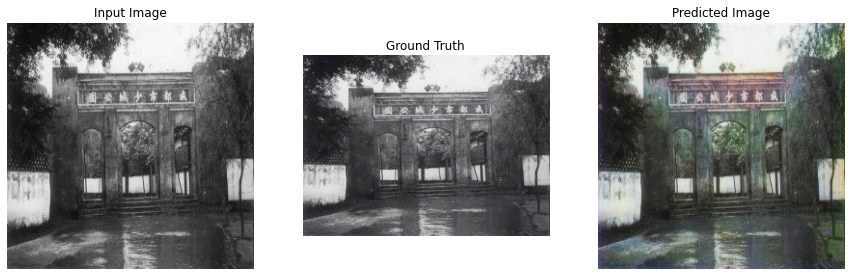

<Figure size 1080x1080 with 0 Axes>

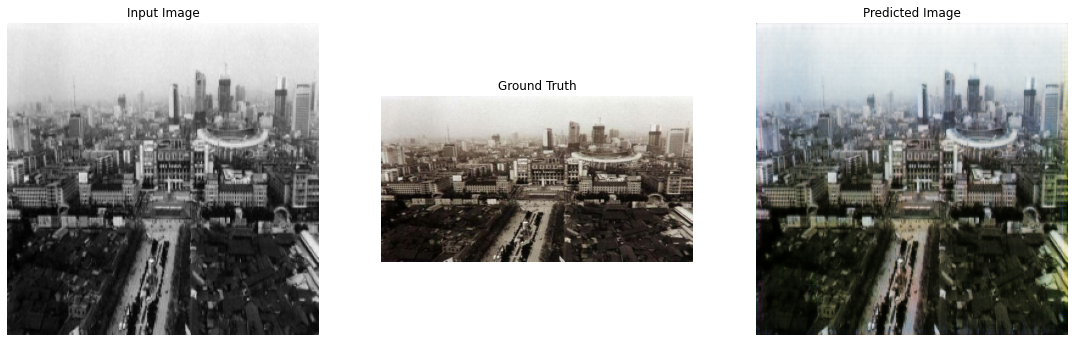

<Figure size 1080x1080 with 0 Axes>

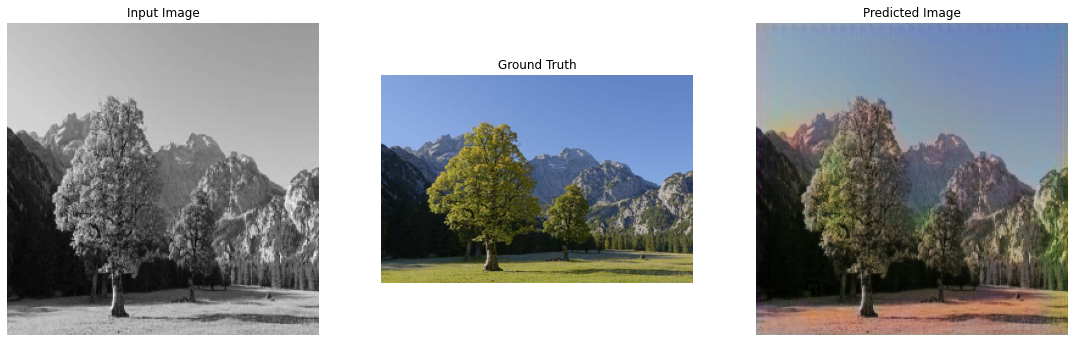

In [98]:
coloring(path1,1)
coloring(path4,4)
coloring(path5,5)
